# CSC413 Lab 2: Word Embeddings

In this lab, we will build a neural network that can predict the next word
in a sentence given the previous three. We will apply an idea called *weight sharing*
to go beyond the multi-layer perceptrons that we discussed in class.

We will also solve this problem problem twice: once in numpy, and once
using PyTorch. When using numpy, you'll implement the backpropagation
computation manually.

The prediction task is not very interesting on its own, but in learning to predict
subsequent words given the previous three, our neural networks will learn
about how to *represent* words. In the last part of the lab, we'll explore
the *vector representations* of words that our model produces,
and analyze these representations.

Acknowledgements:

- Based on an assignment by George Dahl, Jing Yao Li, Roger Grosse, and Lisa Zhang
- Modification by Umangi Jain, Aida Ramezani, and Claas Voelcker

## Submission

Submit the ipynb file `lab02.ipynb` on Markus.
Your notebook file must contain your code, the required equations, **and outputs** where applicable,
including printed lines and images.
Your TA will not run your code for the purpose of grading.

For this lab, you should submit the tasks marked as **Graded Task**.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Part 1. Data

We will begin by downloading the data onto Google Colab.

In [ ]:
# Download lab data file
!wget https://www.cs.toronto.edu/~lczhang/413/raw_sentences.txt

--2024-02-02 20:37:51--  https://www.cs.toronto.edu/~lczhang/413/raw_sentences.txt
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2955731 (2.8M) [text/plain]
Saving to: ‘raw_sentences.txt’

raw_sentences.txt   100%[===================>]   2.82M  9.40MB/s    in 0.3s    

2024-02-02 20:37:51 (9.40 MB/s) - ‘raw_sentences.txt’ saved [2955731/2955731]



With any machine learning problem, the first thing that we would want to do
is to get an intuitive understanding of what our data looks like.
The following code reads the sentences in our file, split each sentence into
its individual words, and stores the sentences (list of words) in the
variable `sentences`.

In [ ]:
sentences = []
for line in open('raw_sentences.txt'):
    words = line.split()
    sentence = [word.lower() for word in words]
    sentences.append(sentence)

There are 97,162 sentences in total, and
these sentences are composed of 250 distinct words.

In [ ]:
vocab = set([w for s in sentences for w in s])
print(len(sentences)) # 97162
print(len(vocab)) # 250

97162
250


We will separate our data into training, validation, and test.
We will use 10,000 sentences for test, 10,000 for validation, and
the remaining for training.

In [ ]:
# First, randomly shuffle the sentences in case these sentences are
# temporally correlated (i.e., so that our train/val/test sets have
# equal probability of getting the earlier vs later sentences)
import random
random.seed(10)
random.shuffle(sentences)

test, valid, train = sentences[:10000], sentences[10000:20000], sentences[20000:]

**Task**: To get an understanding of the data set that we are working with,
start by printing 10 sentences in the training set.
How are punctuated treated in this word representation? What about
words with apostrophes?

In [ ]:
# TODO: Your code goes here
for sent in train[:10]:
    print(sent)

# punctuations and apostrophes are all treated as tokens

['and', 'we', 'did', 'it', 'very', 'well', '.']
['there', ',', 'he', 'says', '.']
['they', 'can', 'see', 'them', ',', 'but', 'they', 'can', 'not', 'get', 'to', 'them', '.']
['he', 'could', 'have', 'an', 'off', 'day', '.']
['that', "'s", 'all', 'the', 'people', 'know', '.']
['but', 'that', "'s", 'just', 'what', 'it', 'was', '.']
['she', 'did', 'nt', 'have', 'that', '.']
['but', 'will', 'it', '?']
['i', 'can', 'see', 'that', ',', 'he', 'said', '.']
['people', 'do', 'nt', 'get', 'it', ',', 'he', 'said', '.']


It is also a good idea to explore the distributional properties of the data.

**Task**: The length of the sentences affects the types of modeling we can perform
on the data. If the sentences are too short, then using a model that depends on many
previous words would not make sense. Run the below code, which computes the length
of the shortest, average, and longest sentences in the training set.

In [ ]:
sentence_lengths = [len(s) for s in train]
print("Shortest Sentence", np.min(sentence_lengths))
print("Average Sentence", np.mean(sentence_lengths))
print("Longest Sentence", np.max(sentence_lengths))

Shortest Sentence 4
Average Sentence 7.793836344314559
Longest Sentence 43


**Task**: How many words are in the training set?
In general, there may be words in the validation/test sets that are *not* in training!

In [ ]:
# TODO: Write code to perform the computation
train_vocab = set([w for s in train for w in s])
print(len(train_vocab))

250


**Task**: What is the most common word in the training set?
How often does this word appear in the training set?
This information is useful to know since it helps us understand
the difficult of the word prediction problem. In other words, this
figure represents the *accuracy* of a "baseline" model that
simply returns the most common word as the prediction for what the next word should
be!

In [ ]:
from collections import Counter

total_words = 0        # count number of words in the training set
word_count = Counter() # count the occurrence of each word
for s in train:
    for w in s:
        word_count[w] += 1
        total_words += 1

# TODO: find the most common word
max_occ_word = ''
max_occ = 0
for k, v in word_count.items():
    if max_occ < v:
        max_occ = v
        max_occ_word = k

print(f'{max_occ_word} appears {max_occ} times')

. appears 64303 times


Now that we understand a bit about the distributional properties of our data,
we can move on to representing our data numerically in a way that a neural network
can use.

We will use a one-hot encoding to represent words. Alternatively,
you can think of what we're doing as assigning each word to a unique integer index.
We will need some functions that converts sentences into the corresponding
word indices.

**Graded Task**: Complete the helper functions `convert_words_to_indices`.
The functions `generate_4grams` and `process_data` have been written
for you. The `process_data` function will take a
list of sentences (i.e. list of list of words), and generate an
$N \times 4$ numpy matrix containing indices of 4 words that appear
next to each other. You can use the constants `vocab`, `vocab_itos`,
and `vocab_stoi` in your code.

In [ ]:
# A list of all the words in the data set. We will assign a unique
# identifier for each of these words.
vocab = sorted(list(set([w for s in train for w in s])))
# A mapping of index => word (string)
vocab_itos = dict(enumerate(vocab))
# A mapping of word => its index
vocab_stoi = {word:index for index, word in vocab_itos.items()}

def convert_words_to_indices(sents):
    """
    This function takes a list of sentences (list of list of words)
    and returns a new list with the same structure, but where each word
    is replaced by its index in `vocab_stoi`.

    Example:
    >>> convert_words_to_indices([['one', 'in', 'five', 'are', 'over', 'here'],
                                  ['other', 'one', 'since', 'yesterday'],
                                  ['you']])
    [[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]]
    """
    indices = []
    # TODO: Write your code here
    for sent in sents:
        indices.append([vocab_stoi[w] for w in sent])
    return indices

def generate_4grams(seqs):
    """
    This function takes a list of sentences (list of lists) and returns
    a new list containing the 4-grams (four consecutively occurring words)
    that appear in the sentences. Note that a unique 4-gram can appear multiple
    times, one per each time that the 4-gram appears in the data parameter `seqs`.

    Example:

    >>> generate_4grams([[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]])
    [[148, 98, 70, 23], [98, 70, 23, 154], [70, 23, 154, 89], [151, 148, 181, 246]]
    >>> generate_4grams([[1, 1, 1, 1, 1]])
    [[1, 1, 1, 1], [1, 1, 1, 1]]
    """
    grams = []
    for seq in seqs:
        for i in range(len(seq) - 3):
            grams.append(seq[i:i+4])
    return grams

def process_data(sents):
    """
    This function takes a list of sentences (list of lists), and generates an
    numpy matrix with shape [N, 4] containing indices of words in 4-grams.
    """
    indices = convert_words_to_indices(sents)
    fourgrams = generate_4grams(indices)
    return np.array(fourgrams)

train4grams = process_data(train)
valid4grams = process_data(valid)
test4grams = process_data(test)

**Task**: We are almost ready to discuss the model. Review the following helper
functions, which has been written for you:

- `make_onehot`, which converts indices

In [ ]:
def make_onehot(indicies, total=250):
    """
    Convert indicies into one-hot vectors.

    Parameters:
        `indices` - a numpy array of any shape (e.g. `[N, 3]` where `N`
                    is the batch size)
        `total` - an integer describing the total number of possible classes
                  (maximum possible value in `indicies`)

    Returns: a one-hot representation of the input numpy array
             (If the input is of shape `[X, Y]`, then the output would
             be of shape `[X, Y, total]` and consists of 0's and 1's)
    """
    # create an identity matrix of shape [total, total]
    I = np.eye(total)
    # index the appropriate columns of that identity matrix
    return I[indicies]

def softmax(x):
    """
    Compute the softmax of vector x, or row-wise for a matrix x.
    We subtract x.max(axis=0) from each row for numerical stability.

    Parameters:
        `x` - a numpy array shape `[N, num_classes]`

    Returns: a numpy array of the same shape as the input.
    """
    x = x.T
    exps = np.exp(x - x.max(axis=0))
    probs = exps / np.sum(exps, axis=0)
    return probs.T

There is one more data processing function that we need,
which turns the four-grams into inputs (consisting of the
one-hot representations of the first 3 words),
and the target output (the index of the 4th word).

Since the one-hot representation is not memory efficient, we will
only convert data into this representation when required, and only
do so at a minibatch level.

In [ ]:
def get_batch(data, range_min, range_max, onehot=True):
    """
    Convert one batch of data (specifically, `data[range_min:range_max]`)
    in the form of 4-grams into input and output data and return the
    training data.

    Parameters:
        `data` - a numpy array of shape [N, 4] produced by a call
                 to the function `process_data`
        `range_min` - the starting index of the minibatch
        `range_max` - the ending index of the minibatch, with
                      range_max > range_min and
                      batch_size = range_max - range_min
        `onehot` - boolean value, if `True` the targets are also made
                   to be one-hot vectors rather than indices

    Returns: a tuple `(x, t)` where
     - `x` is an numpy array of one-hot vectors of shape [batch_size, 3, 250]
     - `t` is either
            - a numpy array of shape [batch_size, 250] if onehot is True,
            - a numpy array of shape [batch_size] containing indicies otherwise
    """
    x = data[range_min:range_max, :3]
    x = make_onehot(x)
    x = x.reshape(-1, 750)
    t = data[range_min:range_max, 3]
    if onehot:
        t = make_onehot(t).reshape(-1, 250)
    return x, t

# some testing code for illustrative purposes
x_, t_ = get_batch(train4grams, 0, 10, onehot=False)
print(train4grams[0])
pos_index = train4grams[0][0]
print(x_[0, pos_index-1]) # should be 0
print(x_[0, pos_index])   # should be 1
print(x_[0, pos_index+1]) # should be 0
pos_index = train4grams[1][0]
print(x_[0, 250 + pos_index-1]) # should be 0
print(x_[0, 250 + pos_index])   # should be 1
print(x_[0, 250 + pos_index+1]) # should be 0
pos_index = train4grams[2][0]
print(x_[0, 500 + pos_index-1]) # should be 0
print(x_[0, 500 + pos_index])   # should be 1
print(x_[0, 500 + pos_index+1]) # should be 0

[ 20 225  55 102]
0.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0


Finally, the `estimate_accuracy` function has been provided to you
as well. This function is similar to the `accuracy` function from
lab 1.

In [ ]:
def estimate_accuracy(model, data, batch_size=5000, max_N=10000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at least `max_N` elements of `data` to
    produce the estimate.

    Parameters:
        `model` - an object (e.g. `NNModel`, see below) with a forward()
                  method that produces predictions for an input
        `data` - a dataset of 4grams (produced by `process_data`) over
                 which we compute accuracy
        `batch_size` - integer batch size to use to produce predictions
        `max_N` - integer value describing the minimum number of predictions
                  to make to produce the accuracy estimate

    Returns: a floating point value between 0 and 1
    """
    num_correct = 0
    num_preds = 0
    for i in range(0, data.shape[0], batch_size):
        xs, ts = get_batch(data, i, i + batch_size, onehot=False)
        z = model.forward(xs)
        pred = np.argmax(z, axis=1)
        num_correct += np.sum(ts == pred)
        num_preds += ts.shape[0]

        if num_preds >= max_N: # at least max_N predictions have been made
            break
    return num_correct / num_preds

## Part 2. Model Building: Forward Pass

In this section, we will build our deep learning model.
As we did in the previous lab, we begin by understanding how to make
predictions with this model.
So, in this part of the lab, we will write the functions
required to perform the forward pass  operation.
We will write the backward-pass and train the model in Part 3 and 4.

**Task**: Consider the following two models architectures:

Model 1:
<img src="https://www.cs.toronto.edu/~lczhang/321/hw/p2_model1.png" />

Model 2:
<img src="https://www.cs.toronto.edu/~lczhang/321/hw/p2_model2.png" />

In Model 1,  the input $\bf{x}$ consists of three one-hot vectors concatenated
together. We can think of $\bf{h}$ as a representation of those three words
(all together).
However, the model architecture treat the three one-hot vectors
from the three words distinctly.
However, $\bf{W^{(1)}}$ needs to learn about the first word
separately from the second and third word. In other words,
the deep learning model treats these three sets of
one-hot features as if they have no semantic connection in common.

In *Model 2*, we use an idea called *weight sharing*, where we use the
sample set of weights $\bf{W}^{(word)}$ to map the one-hot vectors into
a vector representation. This allows us to learn the weights $\bf{W}^{(word)}$
from information from all three words. This model architecture encodes our
knowledge that the three sets of one-hot vectors share something in common.

We will use model 2 in the rest of this lab. For clarity, here is the
forward-pass computation to be performed. (Note that this is *not* vectorized!)

\begin{align*}
\bf{x_a} &= \textrm{the one-hot vector for word 1} \\
\bf{x_b} &= \textrm{the one-hot vector for word 2} \\
\bf{x_c} &= \textrm{the one-hot vector for word 3} \\
\bf{v_a} &= \bf{W}^{(word)} \bf{x_a} \\
\bf{v_b} &= \bf{W}^{(word)} \bf{x_b} \\
\bf{v_c} &= \bf{W}^{(word)} \bf{x_c} \\
\bf{v} &= \textrm{concatenate}(\bf{v_a}, \bf{v_b}, \bf{v_c})\\
\bf{m} &= \bf{W^{(1)}} \bf{v} + \bf{b^{(1)}} \\
\bf{h} &= \textrm{ReLU}(\bf{m}) \\
\bf{z} &= \bf{W^{(2)}} \bf{h} + \bf{b^{(2)}} \\
\bf{y} &= \textrm{softmax}(\bf{z}) \\
L &= \mathcal{L}_\textrm{Cross-Entropy}(\bf{y}, \bf{t}) \\
\end{align*}

The class `NNModel` represents this above neural network model.
This class stores the weights and biases of our model.
Moreover, this class will also have methods that use and modify these weights.

Most of the class has been implemented for you, including these methods:

- The `initializeParams()` method, which randomly initializes the weights
- The `loss()` method, which computes the average cross-entropy loss
- The `update()` method, which performs the gradient updates
- The `cleanup()` method, which clears the member variables used in the computation

The implementation for these methods are incomplete:

- The `forward` method computes the prediction given a data matrix `X`.
  These computations are known as the **forward pass**.
  This method also saves some of the intermediate values in the neural network
  computation, to make gradient computation easier.
- The `backward` method computes the gradient of the average loss
  with respect to various quantities (i.e. the error signals).
  These computations are known as the **backward pass**.

You may assume that during an iteration of gradient descent, the following methods
will be called in order:

- The `cleanup` method to clear information stored from the previous computation
- The `forward` method to compute the predictions
- The `backward` method to compute the error signals
- (Possibly the `loss` method to compute the average loss)
- The `update` method to move the weights

You might recognize that the way we set up the class correspond to what PyTorch does.

In [ ]:
class NNModel(object):
    def __init__(self, vocab_size=250, emb_size=150, num_hidden=100):
        """
        Initialize the weights and biases of this two-layer MLP.
        """
        # information about the model architecture
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.num_hidden = num_hidden

        # weights for the embedding layer of the model
        self.Ww = np.zeros([vocab_size, emb_size])

        # weights and biases for the first layer of the MLP
        self.W1 = np.zeros([emb_size * 3, num_hidden])
        self.b1 = np.zeros([num_hidden])

        # weights and biases for the second layer of the MLP
        self.W2 = np.zeros([num_hidden, vocab_size])
        self.b2 = np.zeros([vocab_size])

        # initialize the weights and biases
        self.initializeParams()

        # set all values of intermediate variables (to be used in the
        # forward/backward passes) to None
        self.cleanup()

    def initializeParams(self):
        """
        Initialize the weights and biases of this two-layer MLP to be random.
        This random initialization is necessary to break the symmetry in the
        gradient descent update for our hidden weights and biases. If all our
        weights were initialized to the same value, then their gradients will
        all be the same!
        """
        self.Ww = np.random.normal(0, 2/self.vocab_size, self.Ww.shape)
        self.W1 = np.random.normal(0, 2/(3*self.emb_size), self.W1.shape)
        self.b1 = np.random.normal(0, 2/(3*self.emb_size), self.b1.shape)
        self.W2 = np.random.normal(0, 2/self.num_hidden, self.W2.shape)
        self.b2 = np.random.normal(0, 2/self.num_hidden, self.b2.shape)

    def forward(self, X):
        """
        Compute the forward pass to produce prediction logits.

        Parameters:
            `X` - A numpy array of shape (N, self.vocab_size * 3)

        Returns: A numpy array of logit predictions of shape
                 (N, self.vocab_size)
        """
        return do_forward_pass(self, X) # To be implemented below

    def backward(self, ts):
        """
        Compute the backward pass, given the ground-truth, one-hot targets.

        You may assume that the `forward()` method has been called for the
        corresponding input `X`, so that the quantities computed in the
        `forward()` method is accessible.

        Parameters:
            `ts` - A numpy array of shape (N, self.vocab_size)
        """
        return do_backward_pass(self, ts)

    def loss(self, ts):
        """
        Compute the average cross-entropy loss, given the ground-truth, one-hot targets.

        You may assume that the `forward()` method has been called for the
        corresponding input `X`, so that the quantities computed in the
        `forward()` method is accessible.

        Parameters:
            `ts` - A numpy array of shape (N, self.num_classes)
        """
        return np.sum(-ts * np.log(self.y)) / ts.shape[0]

    def update(self, alpha):
        """
        Compute the gradient descent update for the parameters of this model.

        Parameters:
            `alpha` - A number representing the learning rate
        """
        self.Ww = self.Ww - alpha * self.Ww_bar
        self.W1 = self.W1 - alpha * self.W1_bar
        self.b1 = self.b1 - alpha * self.b1_bar
        self.W2 = self.W2 - alpha * self.W2_bar
        self.b2 = self.b2 - alpha * self.b2_bar

    def cleanup(self):
        """
        Erase the values of the variables that we use in our computation.
        """
        # To be filled in during the forward pass
        self.N = None # Number of data points in the batch
        self.xa = None # word (a)'s one-hot encoding
        self.xb = None # word (b)'s one-hot encoding
        self.xc = None # word (c)'s one-hot encoding
        self.va = None # word (a)'s embedding
        self.vb = None # word (b)'s embedding
        self.vc = None # word (c)'s embedding
        self.v = None  # concatenated embedding
        self.m = None  # pre-activation hidden state
        self.h = None  # post-activation hidden state
        self.z = None  # prediction logit
        self.y = None  # prediction softmax

        # To be filled in during the backward pass
        self.z_bar  = None # The error signal for self.z
        self.W2_bar = None # The error signal for self.W2
        self.b2_bar = None # The error signal for self.b2
        self.h_bar  = None # The error signal for self.h
        self.m_bar  = None # The error signal for self.z1
        self.W1_bar = None # The error signal for self.W1
        self.b1_bar = None # The error signal for self.b1
        self.v_bar  = None # The error signal for self.v
        self.va_bar = None # The error signal for self.va
        self.vb_bar = None # The error signal for self.vb
        self.vc_bar = None # The error signal for self.vc
        self.Ww_bar = None # The error signal for self.Ww

**Graded Task**: Complete the implementation of the `do_forward_pass` method,
which computes the predictions given a `NNModel` and a batch of input data.

We recommend that you reason about your approach on paper before writing any numpy code.
Track the shapes of your quantities carefully! When you finally write your
numpy code, print out the shapes of your quantities as you go along, and
reason about whether these shapes match your initial expectations.

In [ ]:
def do_forward_pass(model, X):
    """
    Compute the forward pass to produce prediction logits.

    This function also keeps some of the intermediate values in
    the neural network computation, to make computing gradients easier.

    For the ReLU activation, you may find the function `np.maximum` helpful

    Parameters:
        `model` - An instance of the class NNModel
        `X` - A numpy array of shape (N, model.vocab_size)

    Returns: A numpy array of logit predictions of shape
             (N, model.vocab_size)
    """
    # populate the input attributes necessary for the
    # backward pass
    model.N = X.shape[0]
    model.X = X

    # for xa, xb, xc, we index the appropriate range of X
    # (recall that the tensor X has shape [batch_size, 3*vocab_size])
    model.xa = X[:, :model.vocab_size]
    model.xb = X[:, model.vocab_size:model.vocab_size*2]
    model.xc = X[:, model.vocab_size*2:]

    # compute the embeddings
    model.va = model.xa @ model.Ww # TO DO
    model.vb = model.xb @ model.Ww # TO DO
    model.vc = model.xc @ model.Ww # TO DO
    model.v = np.concatenate([model.va, model.vb, model.vc], axis=1)

    # compute the remaining part of the forward pass
    model.m = model.v @ model.W1 + model.b1 # TO DO - the hidden state value (pre-activation)
    model.h = np.maximum(0, model.m) # TO DO - the hidden state value (post ReLU activation)
    model.z = model.h @ model.W2 + model.b2 # TO DO - the logit scores (pre-activation)
    model.y = softmax(model.z) # TO DO - the class probabilities (post-activation)
    return model.y

**Task**: One way important way to check your implementation is to run the
`forward()` method to ensure that the shapes of your quantities are correct.
Run the below code. If you run into shape mismatch issues, print out the
shapes of the quantities that you are working with (e.g. `print(model.va.shape)`)
and ensure that these shapes are what you expect them to be.

In [ ]:
# Create a batch of data that we will use for gradient checking
# we will use a small batch size of 8. This number is chosen
# because it is small, but also because this shape does not
# appear elsewhere in our architecture (e.g. vocab size, num hidden)
# so that shape mismatch issues are easier to identify.
x_, t_ = get_batch(train4grams, 0, 8)
model = NNModel()
y = model.forward(x_)

# TODO: Check that these shapes are correct. What should these shapes be?
print(model.va.shape, model.vb.shape, model.vc.shape)
print(model.v.shape)
print(model.m.shape, model.h.shape)
print(model.z.shape, model.y.shape)

(8, 150) (8, 150) (8, 150)
(8, 450)
(8, 100) (8, 100)
(8, 250) (8, 250)


At this point, we can work with a pre-trained model by loading
weights that are provided to you via the link below.
If you would like, you can jump to part 4 first and explore the
interesting properties of this model before tackling backpropagation
and model training.

In [ ]:
!wget https://www.cs.toronto.edu/~lczhang/413/sentence_pretrained.pk


def load_pretrained(model):
    import pickle
    assert(model.vocab_size == 250)
    assert(model.emb_size   == 150)
    assert(model.num_hidden == 100)
    Ww, W1, b1, W2, b2 = pickle.load(open("sentence_pretrained.pk", "rb"))
    model.Ww = Ww
    model.W1 = W1
    model.b1 = b1
    model.W2 = W2
    model.b2 = b2
    model.cleanup()
    return model

model = load_pretrained(NNModel())

--2024-02-02 20:37:55--  https://www.cs.toronto.edu/~lczhang/413/sentence_pretrained.pk
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 863119 (843K) [application/x-tex-pk]
Saving to: ‘sentence_pretrained.pk’

sentence_pretrained 100%[===================>] 842.89K  3.32MB/s    in 0.2s    

2024-02-02 20:37:56 (3.32 MB/s) - ‘sentence_pretrained.pk’ saved [863119/863119]



## Part 3. Model Building: Backwards Pass

We are ready to complete the function that computes the backward pass of
our model!

You should start by reviewing the lecture slides on backpropagation.
One difference between the slides and our implementation here is that the
slides express the required computations for computing the gradients of
the loss for a *single data point*.
However, our implementation of backpropagation is further vectorized to
compute gradients of the loss for a *batch consisting of multiple data points*.

We begin with applying the backpropagation algorithm on our forward pass
steps from earlier. Recall that our model's forward pass is as follows:

\begin{align*}
\bf{x_a} &= \textrm{the one-hot vector for word 1} \\
\bf{x_b} &= \textrm{the one-hot vector for word 2} \\
\bf{x_c} &= \textrm{the one-hot vector for word 3} \\
\bf{v_a} &= \bf{W}^{(word)} \bf{x_a} \\
\bf{v_b} &= \bf{W}^{(word)} \bf{x_b} \\
\bf{v_c} &= \bf{W}^{(word)} \bf{x_c} \\
\bf{v} &= \textrm{concatenate}(\bf{v_a}, \bf{v_b}, \bf{v_c})\\
\bf{m} &= \bf{W^{(1)}} \bf{v} + \bf{b^{(1)}} \\
\bf{h} &= \textrm{ReLU}(\bf{m}) \\
\bf{z} &= \bf{W^{(2)}} \bf{h} + \bf{b^{(2)}} \\
\bf{y} &= \textrm{softmax}(\bf{z}) \\
L &= \mathcal{L}_\textrm{Cross-Entropy}(\bf{y}, \bf{t}) \\
\end{align*}

Following the steps discussed in this week's lecture, derive the
backwards steps (Hint: your math homework 01 could help a lot in doing
this).
\begin{align*}
\overline{{\bf z}}  &= \dots\\
\overline{W^{(2)}}  &= \dots \\
\overline{{\bf b^{(2)}}}  &= \dots \\
\overline{{\bf h}}  &= \dots \\
\overline{{\bf z}} &= \dots \\
\overline{W^{(1)}} &= \dots \\
\overline{{\bf b}^{(1)}} &= \dots \\
\overline{{\bf m}}  &= \dots \\
\overline{{\bf v}} &= \dots \\
\overline{{\bf v_a}} &= \dots \\
\overline{{\bf v_b}} &= \dots \\
\overline{{\bf v_c}} &= \dots \\
\overline{{\bf W^{(word)}}} &= \dots \\
\end{align*}

**Graded Task**: What is the error signal $\overline{{\bf v_a}}$?
How does this quantity relate to $\overline{{\bf v}}$?
To answer this question, reason about the scalars that make up the elements of
$\overline{{\bf v}}$. Which of these scalars also appear in  $\overline{{\bf v_a}}$?

Express your answer by computing `va_bar` (representing the quantity  $\overline{{\bf v_a}}$)
given `v_bar` (representing the quantity  $\overline{{\bf v}}$).

In [ ]:
N = 10
emb_size = 100
v_bar = np.random.rand(N, emb_size * 3)

va_bar = v_bar[:, :emb_size] # TO DO
vb_bar = v_bar[:, emb_size:2*emb_size] # TODO
vc_bar = v_bar[:, 2*emb_size:] # TODO
# print(v_bar - np.concatenate([va_bar, vb_bar, vc_bar], axis=1))

**Graded Task**: What is the derivative $\overline{{\bf W^{(word)}}}$?
You may find it helpful to draw a computation graph,
and then remember the multivariate chain rule. If $\overline{{\bf W^{(word)}}}$ affects the
loss in 3 different paths, what do we do with those 3 gradients?

In [ ]:
# TODO: Work out the derivative on paper and give the final equation here
"""
Ww_bar = xa.T @ va_bar + xb.T @ vb_bar + xc.T @ vc_bar
"""

'\nWw_bar = xa.T @ va_bar + xb.T @ vb_bar + xc.T @ vc_bar\n'

We are still not done:
the gradient computation is for a single input ${\bf x}$.
We will need to vectorize each of these computations so that they work
for an entire batch of inputs ${\bf X}$ of shape $N \times 3\textrm{vocab_size}$.

For some quantities, vectorizing the backward-pass computation is just as
straightforward as the forward-pass computation, requiring the same
techniques. For example, each
input ${\bf x}$ in a batch will have its own corresponding value of
${\bf z}$ and thus $\overline{{\bf z}}$. (If this sentence is confusing,
check that your description of the shape for `z_bar` from Part 2 has the
batch size `N` in there somewhere.)

For other quantities, vectorizing requires the use of the multivariate chain rule.
For example, there is a single weight matrix $W^{(2)}$, used for all
inputs in a batch. Thus, a change in $W^{(2)}$ will affect the predictions for
*all* inputs. (If this sentence is confusing,
check that your description of the shape for `W2_bar` from Part 2
**does not** have batch size `N` in there.)

The vectorization for the quantities consistent with those of a MLP is
already provided to you in the `do_backward_pass` function.
However, the rest of this function is incomplete.

**Graded Task**: Complete the implementation of the `do_backward_pass` function,
which performs backpropagation given a `NNModel`, given the ground-truth
one-hot targets `ts`. This function assumes that the forward pass method had been
called on the input `X` corresponding to those one-hot targets.

Once again, we recommend that you reason about your approach on paper before
writing any numpy code! In particular, understand the vectorization strategies
discussed in the previous weeks and above before proceeding.
Track the shapes of your quantities carefully! When you finally write your
numpy code, print out the shapes of your quantities as you go along, and
reason about whether these shapes match your initial expectations.

In [ ]:
def do_backward_pass(model, ts):
    """
    Compute the backward pass, given the ground-truth, one-hot targets.

    You may assume that `model.forward()` has been called for the
    corresponding input `X`, so that the quantities computed in the
    `forward()` method is accessible.

    The member variables you store here will be used in the `update()`
    method. Check that the shapes match what you wrote in Part 2.

    Parameters:
        `model` - An instance of the class NNModel
        `ts` - A numpy array of shape (N, model.num_classes)
    """
    # The gradient signal for the MLP part of this is given
    # to you (or worked out together from above, TODO)
    N = ts.shape[0]
    model.z_bar = (model.y - ts) / N # TO DO (AVERAGE L_SCE!!)
    model.W2_bar = model.h.T @ model.z_bar # TO DO
    model.b2_bar = np.sum(model.z_bar, axis=0) # TODO
    model.h_bar = model.z_bar @ model.W2.T # TODO
    model.m_bar = model.h_bar * (model.m > 0).astype(int)  # TODO

    model.W1_bar = model.v.T @ model.m_bar # TODO
    model.b1_bar = np.sum(model.m_bar, axis=0) # TODO
    model.v_bar = model.m_bar @ model.W1.T  # TODO

    # Refer to your answer above
    emb = model.emb_size
    model.va_bar = model.v_bar[:, :emb] # TODO
    model.vb_bar = model.v_bar[:, emb:2*emb] # TODO
    model.vc_bar = model.v_bar[:, 2*emb:] # TODO

    # Refer to your answer above
    model.Ww_bar = model.xa.T @ model.va_bar + model.xb.T @ model.vb_bar + model.xc.T @ model.vc_bar

As we saw in CSC311, debugging machine learning code can be extremely
challenging.
It helps to **be systematic about testing**, and to test every helper
function as we write it.
It is important to test `do_backward_pass` before using it for training,
so that we can isolates issues related to computing gradients vs. other
training issues (e.g. those related to poor hyperparameter choices).

**Task**: As in the forward pass,
start by making sure that the shapes match.
Again, If you run into shape mismatch issues, print out the
shapes of the quantities that you are working with.

In [ ]:
x_, t_ = get_batch(train4grams, 0, 8)
model = NNModel()

model.forward(x_)
model.backward(t_)
model.update(0.001)

The above step checks that the shapes match.
But we also saw, in CSC311, that one way to check the gradient
computation is through **finite difference**.
Recall the definition of a derivative.
For a function $g(w): \mathbb{R} \rightarrow \mathbb{R}$,

$$g'(w) = \lim_{h \rightarrow 0} \frac{g(w+h) - g(w)}{h}$$

This above rule tells us that if we have a way to evaluate `g` and would like to
test our implementation of $g'$, we can choose an $h$ small enough, and check if:

$$g'(w) \approx \frac{g(w+h) - g(w)}{h}$$

In our case, we have that for any parameter $w_j$ and an $h$ small enough,
we should have for our loss $$\mathcal{E}$$:

$$\frac{\partial \mathcal{E}}{\partial w_j} \approx \frac{\mathcal{E}(w_0, w_1, \dots, w_{j-1}, w_j + h, w_{j+1}, \dots, w_D) - \mathcal{E}(w_0, w_1, \dots, w_D)}{h}$$


(A word about notation: here we are enumerating over all scalar weights
$w_0 \dots w_D$ in our model. You will often see this in machine learning
textbooks and papers, where we ignore the fact that these scalar weights come
from several different weight matrices and bias vectors.
This notation might feel strange/imprecise as first, but keep in mind that
mathematical notations is a form of language whose purpose is to communicate
ideas. Practitioners choose different notations, and even introduce new notation,
with the goal of clearly communicating a specific idea. Here, the idea is that
we should be able to test the gradient computation or a single scalar weight by
computing the loss function twice: once with a slight perturbation on that
scalar weight.)

**Graded Task:** Run the below code to spot test that the gradients `Ww_bar` is
computed correctly. Include the output of the code in your submission.

In [ ]:
# We will opt to use a large batch size to test the gradients `Ww_bar`
# with a large batch size. Why do you think this is? (Why might we
# be more likely to have gradients of value 0 if the batch size is
# small?)
x_, t_ = get_batch(train4grams, 0, 800)

model = NNModel()
model.forward(x_)

# Check the gradient for Ww_bar[3, 10].
# You should spot check other indices too!
model.backward(t_)
gradient = model.Ww_bar[3][10]

# we should have
# gradient ~= (loss_perturbed - loss_initial) / h
# where loss_perturbed is the loss if we perturb
# model.Ww_bar[3, 10] by a small value h

loss_initial = model.loss(t_)
h = 0.01
model.Ww[3][10] += h
model.cleanup()
model.forward(x_)
loss_perturbed = model.loss(t_)

# These two values should be close
print(gradient)
print((loss_perturbed - loss_initial) / h)

3.114896487456132e-05
3.032429871652198e-05


If gradient checking succeeds, we are ready to train our model.
The function `train_model` is written for you. Run the code below
with the default hyperparameters.
Although hyperparameter tuning is an important step in machine learning,
we have chosen reasonable hyperparameters to you to keep this lab
a reasonable size.

Iter 1000. Acc [val:0.1715, train:0.1743] Loss 4.360797792216479]
Iter 2000. Acc [val:0.2186, train:0.2237] Loss 3.7477293428074927]
Iter 3000. Acc [val:0.2564, train:0.2678] Loss 3.311584309603211]
Iter 4000. Acc [val:0.2739, train:0.2841] Loss 3.3382388854997873]
Iter 5000. Acc [val:0.2872, train:0.2951] Loss 3.411482603393873]
Iter 6000. Acc [val:0.293, train:0.3044] Loss 3.3032206674365017]
Iter 7000. Acc [val:0.3009, train:0.3102] Loss 2.738683048449618]
Iter 8000. Acc [val:0.3102, train:0.3186] Loss 3.2120648892485217]
Iter 9000. Acc [val:0.3139, train:0.3196] Loss 2.5639161503615187]
Iter 10000. Acc [val:0.322, train:0.3268] Loss 2.85718209788796]
Iter 11000. Acc [val:0.3235, train:0.3289] Loss 2.735321860399915]
Iter 12000. Acc [val:0.3244, train:0.3264] Loss 2.5869680181732155]
Iter 13000. Acc [val:0.3285, train:0.3315] Loss 2.7971882537692094]
Iter 14000. Acc [val:0.3287, train:0.3348] Loss 3.133243802187513]
Iter 15000. Acc [val:0.3287, train:0.3581] Loss 2.638903005948149]


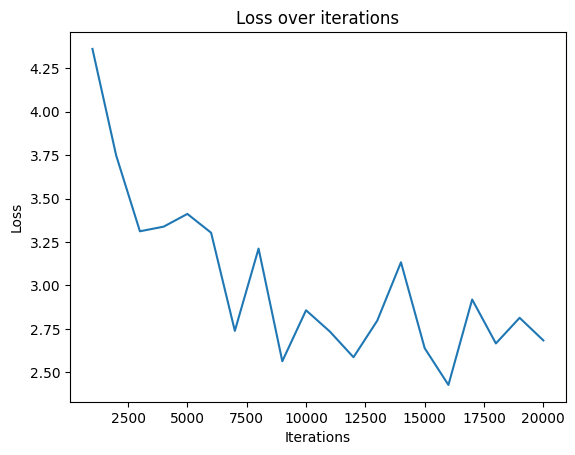

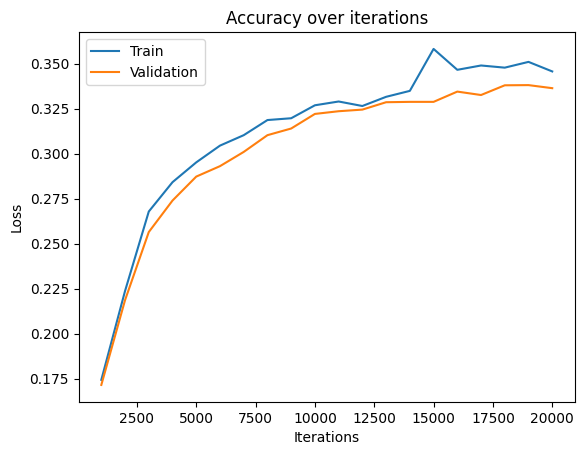

In [ ]:
def train_model(model,
                train_data=train4grams,
                validation_data=valid4grams,
                batch_size=50,
                learning_rate=0.3,
                max_iters=20000,
                plot_every=1000):
    """
    Use gradient descent to train the numpy model on the dataset train4grams.
    """
    iters, train_loss, train_acc, val_acc = [], [], [], [] # for the training curve
    iter_count = 0  # count the number of iterations
    try:
        while iter_count < max_iters:
            # shuffle the training data, and break early if we don't have
            # enough data to remaining in the batch
            np.random.shuffle(train_data)
            for i in range(0, train_data.shape[0], batch_size):
                if (i + batch_size) > train_data.shape[0]:
                    break

                # get the input and targets of a minibatch
                xs, ts = get_batch(train_data, i, i + batch_size, onehot=True)

                # erase any accumulated gradients
                model.cleanup()

                # forward pass: compute prediction
                ys = model.forward(xs)

                # backward pass: compute error
                model.backward(ts)
                model.update(learning_rate)

                # increment the iteration count
                iter_count += 1

                # compute and plot the *validation* loss and accuracy
                if (iter_count % plot_every == 0):
                    iters.append(iter_count)
                    train_loss.append(model.loss(ts))
                    train_acc.append(estimate_accuracy(model, train_data))
                    val_acc.append(estimate_accuracy(model, validation_data))
                    model.cleanup()
                    print(f"Iter {iter_count}. Acc [val:{val_acc[-1]}, train:{train_acc[-1]}] Loss {train_loss[-1]}]")
                if iter_count >= max_iters:
                    break
    finally:
        plt.figure()
        plt.plot(iters[:len(train_loss)], train_loss)
        plt.title("Loss over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")

        plt.figure()
        plt.plot(iters[:len(train_acc)], train_acc)
        plt.plot(iters[:len(val_acc)], val_acc)
        plt.title("Accuracy over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend(["Train", "Validation"])

model= NNModel()
train_model(model)

## Part 4. Applying the Model

In this section, we will use apply the model for sentence completion, and to
explore model embeddings.  If you do not have a trained model, you may use
the trained weights provided as part of the assignment.

In [ ]:
# model = load_pretrained(NNModel())

**Task**: The function `make_prediction` has been written for you.
It takes as parameters
a NNModel model and sentence (a list of words), and produces
a prediction for the next word in the sentence.

Run the following code to predict what the next word should be in each
of the following sentences:

In [ ]:
def make_prediction(model, sentence):
    """
    Use the model to make a prediction for the next word in the
    sentence using the last 3 words (sentence[-3:])
    """
    global vocab_itos
    indices = convert_words_to_indices([sentence[-3:]])
    X = make_onehot(indices).reshape(-1, 750)
    z = model.forward(X)
    i = np.argmax(z)
    return vocab_itos[i]

print(make_prediction(model, ['you', 'are', 'a']))
print(make_prediction(model, ['there', 'are', 'no']))
print(make_prediction(model, ['yesterday', 'the', 'federal']))

good
one
one


Do your predictions make sense? (If all of your predictions are the same,
train your model for more iterations, or change the hyper parameters in your
model.

In [ ]:
# TODO: Your analysis goes here
"""
Yes they make sense as they can be expanded to reasonable sentences
"""

'\nYes they make sense as they can be expanded to reasonable sentences\n'

While training the `NNModel`, we trained the weight `model.Ww`, which takes a one-hot
representation of a word in our vocabulary, and returns a low-dimensional vector
representation of that word.
These representations, also called **word embeddings** have interesting properties.

**Graded Task:**
Explain why each *row* of `model.Ww` contains the vector representing
of a word. For example `model.Ww[vocab_stoi["any"],:]` contains the
vector representation of the word "any".

In [ ]:
# TODO: Write your explanation here
"""
Since X is a one-hot matrix where each line uses one-hot encoding to represent a
specific word, by multiplying x_a, x_b or x_c with Ww, only the word 'any' can
multiply with model.Ww[vocab_stoi["any"],:] and has a value.
"""

'\nSince X is a one-hot matrix where each line uses one-hot encoding to represent a\nspecific word, by multiplying x_a, x_b or x_c with Ww, only the word \'any\' can\nmultiply with model.Ww[vocab_stoi["any"],:] and has a value.\n'

One interesting thing about these word embeddings is that distances
in these vector representations of words make some sense! To show this,
we have provided code below that computes the cosine similarity of
every pair of words in our vocabulary.

In [ ]:
norms = np.linalg.norm(model.Ww, axis=1)
word_emb_norm = (model.Ww.T / norms).T
similarities = np.matmul(word_emb_norm, word_emb_norm.T)

# Some example distances. The first one should be larger than the second
print(similarities[vocab_stoi['any'], vocab_stoi['many']])
print(similarities[vocab_stoi['any'], vocab_stoi['government']])

0.5843362065775078
-0.25721864893259894


**Task**: Run the below code, which computes the 5 closest words to each of the following words.
Replace these words with words of your choice to explore the distances in the word embeddings.

In [ ]:
def get_closest(word):
    dst = [(w, similarities[vocab_stoi[word], idx])
           for w, idx in vocab_stoi.items()]
    dst = sorted(dst, key=lambda x: x[1], reverse=True)
    return dst[1:6]

print(get_closest("four"))
print(get_closest("go"))
print(get_closest("should"))
print(get_closest("yesterday"))

[('five', 0.9642891774480074), ('three', 0.9533662008281867), ('two', 0.9204592082651724), ('several', 0.86062080821906), ('few', 0.7731454574653761)]
[('back', 0.690660903040023), ('come', 0.5902185691704095), ('going', 0.4732534474564412), ('get', 0.4567528282853905), ('up', 0.4385591414707563)]
[('could', 0.7861450550921396), ('might', 0.7512309376332625), ('would', 0.7254262032874994), ('may', 0.7027923874292511), ('can', 0.6709755607868855)]
[('today', 0.8565143955725616), (')', 0.8553486422140986), ('though', 0.8314424748196485), ('ago', 0.7976371713978956), ('season', 0.7687988020813866)]


Notice that similar words provided above tend to **occur in similar surrounding words**
in a sentence. Why do you think this might be? Consider the architecture used in this model,
and what this model is trained to do. (How would replacing a word with another word with a similar
embedding change the neural network prediction?)

We can also visualize the word embeddings by reducing the dimensionality of
the word vectors to 2D. There are many dimensionality reduction techniques
that we could use, and we will use an algorithm called t-SNE.
(You don’t need to know what this is for the lab).
Nearby points in this 2-D space are meant to correspond to nearby points
in the original, high-dimensional space.

The following code runs the t-SNE algorithm and plots the result.
Look at the plot and find two clusters of related words.
What do the words in each cluster have in common?

Note that there is randomness in the initialization of the t-SNE
algorithm. If you re-run this code, you may get a different image.

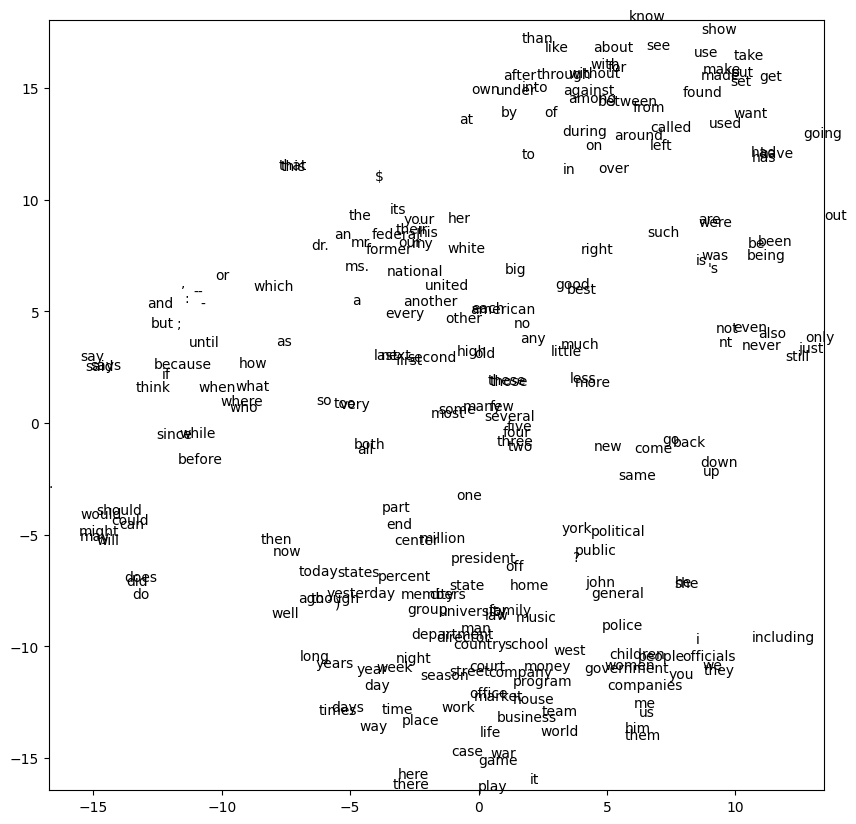

In [43]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE()
Y = tsne.fit_transform(word_emb_norm)

plt.figure(figsize=(10, 10))
plt.xlim(Y[:,0].min(), Y[:, 0].max())
plt.ylim(Y[:,1].min(), Y[:, 1].max())
for i, w in enumerate(vocab):
    plt.text(Y[i, 0], Y[i, 1], w)
plt.show()

```
```